In [135]:
import hydrofunctions as hf
import pandas as pd
import altair as alt
import contextily as ctx
import pyPRISMClimate
import os
import glob
import matplotlib.pyplot as plt
import rioxarray as rix
import xarray as xr
import geopandas as gpd
alt.data_transformers.disable_max_rows()
alt.renderers.enable('jupyterlab')

%matplotlib inline


# Stream flow

In [136]:
# List USGS gages
basin_gages = {
    '12205000': 'North Fork, 12205000',
    '12208000': 'Middle Fork, 12208000',
    '12210000': 'South Fork, 12210000',
    '12210700': 'Main stem, 12210700',
    '12211200': 'Main stem at Everson, 12211200',
    '12213100': 'Main stem at Ferndale, 12213100'
}

In [137]:
# Create a function to parse the confusing datastructure that hydrofunctions returns
def get_usgs_daily_gage_data(gage_id,  code, id_to_name_dict = None, start_date=None, end_date=None, ):
    daily = hf.NWIS(gage_id, code, start_date=start_date, end_date=end_date)
    daily_df = daily.df()

    def replace_col_names(df):
        USGS_PARAMETER_CODE_DICT = {
            '00060': 'Discharge (cfs)',
            '00065': 'Gage height (ft)',
        }
        def replace_col_name(name):
            if '_qualifiers' in name:
                return None
            else:
                name = USGS_PARAMETER_CODE_DICT.get(name.split(':')[2], name.split(':')[2])
                return name

        conversion_dict = dict(zip(
            list(df.columns.to_series()),
            list(df.columns.to_series().apply(replace_col_name))
        ))
        df = df.rename(conversion_dict, axis='columns')
        return df
    #Convert USGS parameter codes to parameter names
    daily_df = replace_col_names(daily_df)
    #Drop any columns that couldn't be interepreted (columns named NaN)
    daily_df = daily_df[[x for x in list(daily_df.columns) if x]]
    daily_df['date'] = daily_df.index
    daily_df = daily_df.melt(id_vars=['date'])
    daily_df['gage'] = gage_id
    if id_to_name_dict:
        daily_df['name'] = id_to_name_dict[gage_id]
    return daily_df

In [138]:
# get streamflow data for each gage and combine into a single dataframe
df = pd.concat([
    get_usgs_daily_gage_data(gage, code='iv', start_date='2021-11-10', end_date='2021-11-24', id_to_name_dict=basin_gages) 
    for gage in basin_gages.keys()
])

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12205000&startDT=2021-11-10&endDT=2021-11-24


Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12208000&startDT=2021-11-10&endDT=2021-11-24


Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12210000&startDT=2021-11-10&endDT=2021-11-24


Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12210700&startDT=2021-11-10&endDT=2021-11-24


Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12211200&startDT=2021-11-10&endDT=2021-11-24


Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=12213100&startDT=2021-11-10&endDT=2021-11-24


In [139]:
df

date variable  value      gage  \
0    2021-11-10 08:00:00+00:00    00010   4.00  12205000   
1    2021-11-10 08:15:00+00:00    00010   4.00  12205000   
2    2021-11-10 08:30:00+00:00    00010   4.00  12205000   
3    2021-11-10 08:45:00+00:00    00010   4.00  12205000   
4    2021-11-10 09:00:00+00:00    00010   4.00  12205000   
...                        ...      ...    ...       ...   
7195 2021-11-25 06:45:00+00:00    99133   0.43  12213100   
7196 2021-11-25 07:00:00+00:00    99133   0.44  12213100   
7197 2021-11-25 07:15:00+00:00    99133   0.43  12213100   
7198 2021-11-25 07:30:00+00:00    99133   0.46  12213100   
7199 2021-11-25 07:45:00+00:00    99133   0.46  12213100   

                                 name  
0                North Fork, 12205000  
1                North Fork, 12205000  
2                North Fork, 12205000  
3                North Fork, 12205000  
4                North Fork, 12205000  
...                               ...  
7195  Main stem at Ferndale, 12213100  
7196  Main stem at Ferndale, 12213100  
7197  Main stem at Ferndale, 12213100  
7198  Main stem at Ferndale, 12213100  
7199  Main stem at Ferndale, 12213100  

[27360 rows x 5 columns]

In [140]:
alt.Chart(df).transform_filter(
    alt.datum.variable == 'Discharge (cfs)'
).mark_line().encode(
    alt.X('date:T', title='Date'),
    alt.Y('value:Q', title='Discharge (cfs)'),
    alt.Color('name')
).properties(width=800).configure_legend(
    orient='top'
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [141]:
df = df[df['date'].dt.day > 11]
df = df[df['date'].dt.day < 19]
df = df[df['gage'].isin(['12205000', '12208000', '12210000', '12210700'])]

In [191]:
(
alt.Chart(df).transform_filter(
    alt.datum.variable == 'Discharge (cfs)'
).mark_line().encode(
    alt.X('date:T', title='Date', axis=alt.Axis(format="Nov. %d", tickCount=7)),
    alt.Y('value:Q', title='Discharge (cfs)'),
    alt.Color('name')
).properties(width=800)
&
alt.Chart(df).transform_filter(
    alt.datum.variable == 'Gage height (ft)'
).mark_line().encode(
    alt.X('date:T', title='Date', axis=alt.Axis(format="Nov. %d", tickCount=7)),
    alt.Y('value:Q', title='Gage height (ft)'),
    alt.Color('name')
).properties(width=800)
).configure_legend(
    orient='top'
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [143]:
df = df.query('variable == "Discharge (cfs)"')
first_event_df = df[df['date'].dt.day == 12]
second_event_df = df[df['date'].dt.day.isin([14,15])]

In [144]:
first_event_peak_flows = pd.concat([group.sort_values('value', ascending=False).iloc[0:1] for _, group in first_event_df.groupby(['gage', 'name'])])
first_event_peak_flows['contribution'] = first_event_peak_flows['value']/first_event_peak_flows['value'].max()
first_event_peak_flows

date         variable    value      gage  \
1675 2021-11-12 18:45:00+00:00  Discharge (cfs)   3540.0  12205000   
223  2021-11-12 15:45:00+00:00  Discharge (cfs)   5650.0  12208000   
1671 2021-11-12 17:45:00+00:00  Discharge (cfs)   6690.0  12210000   
1688 2021-11-12 22:00:00+00:00  Discharge (cfs)  15000.0  12210700   

                       name  contribution  
1675   North Fork, 12205000      0.236000  
223   Middle Fork, 12208000      0.376667  
1671   South Fork, 12210000      0.446000  
1688    Main stem, 12210700      1.000000

In [145]:
second_event_peak_flows = pd.concat([group.sort_values('value', ascending=False).iloc[0:1] for _, group in second_event_df.groupby(['gage', 'name'])])
second_event_peak_flows['contribution'] = second_event_peak_flows['value']/second_event_peak_flows['value'].max()
second_event_peak_flows

date         variable    value      gage  \
1977 2021-11-15 22:15:00+00:00  Discharge (cfs)  15300.0  12205000   
531  2021-11-15 20:45:00+00:00  Discharge (cfs)  17200.0  12208000   
1933 2021-11-15 11:15:00+00:00  Discharge (cfs)  19000.0  12210000   
1983 2021-11-15 23:45:00+00:00  Discharge (cfs)  67500.0  12210700   

                       name  contribution  
1977   North Fork, 12205000      0.226667  
531   Middle Fork, 12208000      0.254815  
1933   South Fork, 12210000      0.281481  
1983    Main stem, 12210700      1.000000

# Precipitation

## Identify watershed boundaries for Nooksack and 3 forks 


In [146]:
wbd_fn = "/Users/elischwat/Downloads/NHDPLUS_H_1711_HU4_GDB/NHDPLUS_H_1711_HU4_GDB.gdb"
nooksack_boundary_df = gpd.read_file(wbd_fn, layer=72).to_crs('EPSG:4326')
nooksack_boundary_df = nooksack_boundary_df[nooksack_boundary_df.Name == 'Nooksack']

In [147]:
gdf = gpd.read_file(
	wbd_fn, 
	layer=65
)
nf_poly = gdf.iloc[6].geometry.union(gdf.iloc[106].geometry)
sf_poly = gdf.iloc[54].geometry
mf_poly = gdf.iloc[80].geometry
forks_gdf = gpd.GeoDataFrame({'name': ['North Fork', 'South Fork', 'Middle Fork'], 'geometry' : [nf_poly, sf_poly, mf_poly]}).set_crs(gdf.crs)

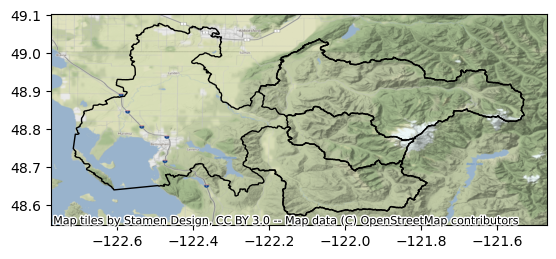

In [148]:
ax = nooksack_boundary_df.plot(facecolor="none")
forks_gdf.plot(facecolor="none", ax=ax)
ctx.add_basemap(ax, crs=nooksack_boundary_df.crs)
plt.show()

# Download CONUS PRISM data and subset to the Nooksack River watershed

In [149]:
def create_weather_dataset(variable, min_date, max_date, dest_path, boundaries_gdf):
    def get_date_from_prism_filename(fn):
        return pd.to_datetime(fn.split('_')[-2], format="%Y%m%d")
    pyPRISMClimate.get_prism_dailys(variable, min_date=min_date, max_date=max_date, dest_path=dest_path, keep_zip=False)
    files = glob.glob(os.path.join(dest_path, '*.bil'))
    print(f'Downloaded {len(files)} files')
    
    rasters = []
    for weather_file in files:
        # open weather file and clip to watershed boundaries
        raster = rix.open_rasterio(weather_file, masked=True)
        raster = raster.rio.clip(
            boundaries_gdf.to_crs(raster.rio.crs).geometry)

        # get date from filename and add as a time coordinate
        date = get_date_from_prism_filename(weather_file)
        raster = raster.expand_dims(dim='time')
        raster.coords['time'] = ('time',[date])

        # delete old file and save new, cropped raster
        os.remove(weather_file)

        #add timestamp to list
        rasters.append(raster)
    weather_dataset = xr.concat(rasters, 'time')
    weather_dataset = weather_dataset.to_dataset(
        name=variable
    )
    weather_dataset.to_netcdf(
        os.path.join(dest_path, 'final_weather_dataset.nc')
    )
    return weather_dataset

In [157]:
weather_dataset = create_weather_dataset(
    variable = 'ppt',
    min_date='2021-11-01',
    max_date='2021-11-24',
    dest_path='weather_data',
    boundaries_gdf=nooksack_boundary_df
)

Downloaded 24 files


<AxesSubplot: title={'center': 'band = 1, spatial_ref = 0, time = 2021-11-16'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

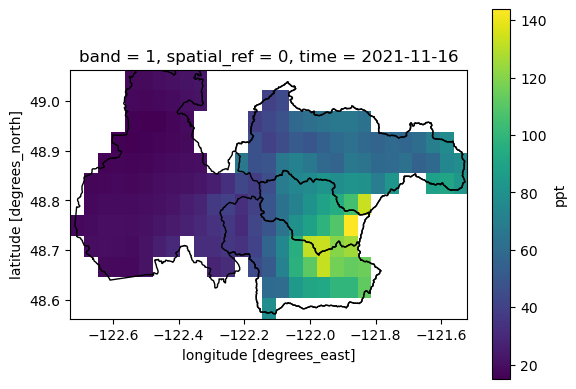

In [158]:
ax = weather_dataset.sel(time="2021-11-16")['ppt'].plot()
nooksack_boundary_df.plot(facecolor="none", ax=plt.gca())
forks_gdf.plot(facecolor="none", ax=plt.gca())

In [159]:
forks_gdf = forks_gdf.to_crs(weather_dataset.rio.crs)

In [160]:
weather_dataset_nf = weather_dataset.rio.clip(forks_gdf.query('name == "North Fork"').geometry).mean(dim=['x', 'y']).to_dataframe().reset_index().sort_values('time')
weather_dataset_nf['name'] = "North Fork"
weather_dataset_sf = weather_dataset.rio.clip(forks_gdf.query('name == "South Fork"').geometry).mean(dim=['x', 'y']).to_dataframe().reset_index().sort_values('time')
weather_dataset_sf['name'] = "South Fork"
weather_dataset_mf = weather_dataset.rio.clip(forks_gdf.query('name == "Middle Fork"').geometry).mean(dim=['x', 'y']).to_dataframe().reset_index().sort_values('time')
weather_dataset_mf['name'] = "Middle Fork"
precip_df = pd.concat([weather_dataset_mf, weather_dataset_nf, weather_dataset_sf])

In [161]:
precip_df

band       time  spatial_ref        ppt         name
2      1 2021-11-01            0   0.000000  Middle Fork
7      1 2021-11-02            0   6.772706  Middle Fork
11     1 2021-11-03            0  25.192835  Middle Fork
22     1 2021-11-04            0  14.674634  Middle Fork
19     1 2021-11-05            0  52.448780  Middle Fork
..   ...        ...          ...        ...          ...
14     1 2021-11-20            0   2.043112   South Fork
15     1 2021-11-21            0   0.000000   South Fork
23     1 2021-11-22            0   0.022037   South Fork
18     1 2021-11-23            0  11.632766   South Fork
9      1 2021-11-24            0  10.882044   South Fork

[72 rows x 5 columns]

In [ ]:
alt.Chart(precip_df).mark_bar().encode(
    alt.X('time:T'),
    alt.Y('ppt:Q'),
    alt.Color('name'),
)

In [189]:
alt.Chart(precip_df).mark_bar().encode(
    alt.X('name:N', axis=alt.Axis(labels=False), title=None),
    alt.Y('ppt:Q', title='Daily Total Precipitation (mm)'),
    alt.Color('name')
).properties(width=20).facet(
    column=alt.Column('time:T', header=alt.Header(format="%d"), title='Day of November 2021'),
    spacing=15
).configure_axis(grid=False).configure_view(strokeWidth=0)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [192]:
precip_df

band       time  spatial_ref        ppt         name
2      1 2021-11-01            0   0.000000  Middle Fork
7      1 2021-11-02            0   6.772706  Middle Fork
11     1 2021-11-03            0  25.192835  Middle Fork
22     1 2021-11-04            0  14.674634  Middle Fork
19     1 2021-11-05            0  52.448780  Middle Fork
..   ...        ...          ...        ...          ...
14     1 2021-11-20            0   2.043112   South Fork
15     1 2021-11-21            0   0.000000   South Fork
23     1 2021-11-22            0   0.022037   South Fork
18     1 2021-11-23            0  11.632766   South Fork
9      1 2021-11-24            0  10.882044   South Fork

[72 rows x 5 columns]

In [195]:
first_event_precip_df = precip_df[precip_df['time'].dt.day.isin([10,11,12])]
second_event_precip_df = precip_df[precip_df['time'].dt.day.isin([13,14,15])]

In [197]:
first_event_precip_df.groupby('name')['ppt'].mean()

name
Middle Fork    22.063482
North Fork     18.682100
South Fork     20.376419
Name: ppt, dtype: float32

In [198]:
second_event_precip_df.groupby('name')['ppt'].mean()

name
Middle Fork    68.000359
North Fork     60.204296
South Fork     66.327217
Name: ppt, dtype: float32

# Calculate mean streamflow discharge for the same date spans

In [200]:
df = df.query('variable == "Discharge (cfs)"')
first_event_meanflow_df = df[df['date'].dt.day.isin([10,11,12])]
second_event_meanflow_df = df[df['date'].dt.day.isin([13,14,15])]

In [202]:
first_event_meanflow_df.groupby(['gage', 'name'])['value'].mean()

gage      name                 
12205000  North Fork, 12205000     1913.822917
12208000  Middle Fork, 12208000    2798.500000
12210000  South Fork, 12210000     3990.000000
12210700  Main stem, 12210700      8318.125000
Name: value, dtype: float64

In [203]:
second_event_meanflow_df.groupby(['gage', 'name'])['value'].mean()

gage      name                 
12205000  North Fork, 12205000      5603.472222
12208000  Middle Fork, 12208000     7146.784722
12210000  South Fork, 12210000      8496.076389
12210700  Main stem, 12210700      19946.929461
Name: value, dtype: float64